In [1]:
%store -d df
%store -d families
%store -d ratings
%store -d ratings_train
%store -d ratings_test
%store -d train
%store -d test
%store -d sim_df
%store -d pred_df
%store -d output
%store -d recommendations

In [2]:
import numpy as np
import pandas as pd
import random
from scipy.stats import pearsonr
from math import isnan
import time

In [3]:
global_time = time.time()
# Read OLO
df=pd.read_excel("../../OLOORDERS.xlsx")

df.columns = [u'WEB', u'CDis', u'Agen come', u'GVen', u'cod_venta', u'Cliente', 
              u'Nombre', u'Posición', u'Fecha crea', u'Producto', u'Descripcion', 
              u'Cantidad', u'UM', u'Venta neta', u'Moneda']

df=df.drop([u'WEB', u'CDis', u'Agen come', u'GVen', u'Nombre'], axis=1)

df.head()

,cod_venta,Cliente,Posición,Fecha crea,Producto,Descripcion,Cantidad,UM,Venta neta,Moneda
0,101303229,40570,10,2016-10-31,000001228,"B.L/C PET BL. 210,0X297,0 20H",1,UN,11.45,EUR
1,101303229,40570,20,2016-10-31,000001270,"C.I/L/C 70,0X 25,4 100H",1,UN,9.74,EUR
2,101303230,13995,10,2016-10-31,000012769,B.GOMA EVA BLANCO 400X600X2MM 5H,1,UN,1.74,EUR
3,101303230,13995,20,2016-10-31,000012768,B.GOMA EVA NEGRO 400X600X2MM 5H,1,UN,1.74,EUR
4,101302933,105277,10,2016-10-28,000010532,"C.MULTI3 210,0X148,0 500H",6,UN,96.00,EUR


In [4]:
#Read families
families=pd.read_csv("../../Dades/Asignacion_productos.csv")
families = families.drop(families.columns[[0, 1, 3, 4, 5, 6, 7, 9, 10]], 1)
families.columns=["Area", "Material"]
print families.shape
families.head()

(2657, 2)


,Area,Material
0,143,000001776
1,143,000001777
2,143,000001778
3,143,000001781
4,143,000001782


In [5]:
# Intersect products from OLO and families
def intersect(a, b):
    return list(set(a) & set(b))

ProductsList=np.unique(np.array(df["Producto"]))
ProductsList_intersect=intersect(ProductsList, families["Material"].values)
df=df.loc[df['Producto'].isin(ProductsList_intersect)]

In [6]:
# Groupby Cliente and ProductsList
gr=df.groupby(["Cliente"])["Producto"].apply(list)
prod=pd.DataFrame(gr)
ProductsList=np.unique(np.array(df["Producto"]))

In [7]:
# Create ratings
start_time = time.time()
ratings=pd.DataFrame(index=prod.index, columns=ProductsList)
ratings=ratings.fillna(0)
for i in np.arange(len(prod)):
    for j in np.arange(len(prod[prod.index==prod.index[i]]["Producto"].values[0])):
        ratings.loc[prod.index[i], prod[prod.index==prod.index[i]]["Producto"].values[0][j]]+=1
print("Minutes: " + str((time.time() - start_time)/60.0))

# Normalize ratings
start_time = time.time()
for user in ratings.index:
    ratings.loc[user]=ratings.loc[user]/ratings.loc[user].sum()
print("Minutes: " + str((time.time() - start_time)/60.0))

Minutes: 5.61658040285
Minutes: 0.304091266791


In [8]:
#Train and test index
np.random.seed(40)
no_null_index={}
for item in ratings.columns:
     no_null_index[item]=ratings[item][ratings[item]!=0.0].index.tolist()

train_index={}
test_index={}
for item in no_null_index.keys():
    test_index[item]=np.random.choice(no_null_index[item], int(0.2*len(no_null_index[item])))
    train_index[item]=list(set(no_null_index[item])-set(test_index[item]))

In [9]:
# Create ratings train
start_time = time.time()
ratings_train=pd.DataFrame(index=prod.index, columns=ProductsList)
ratings_train=ratings_train.fillna(0.0)
for item in train_index.keys():
    for user in train_index[item]:
        ratings_train[item][user]=ratings[item][user]
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area columns
start_time = time.time()
for area in families["Area"].unique():
    area_name="A"+str(area)
    ratings_train[area_name]=0.0
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area ratings_train
start_time = time.time()
for user in ratings_train.index:
    user_ratings_train=ratings_train.loc[user][ratings_train.loc[user]!=0.0]
    for product in user_ratings_train.index:
        area_aux="A"+str(families[product==families["Material"]]["Area"].values[0])
        ratings_train.loc[user][area_aux]=ratings_train.loc[user][area_aux]+user_ratings_train.loc[product]
print("Minutes: " + str((time.time() - start_time)/60.0))

Minutes: 1.67191379865
Minutes: 0.00182421604792
Minutes: 3.87994105021


In [10]:
# Create ratings test
start_time = time.time()
ratings_test=pd.DataFrame(index=prod.index, columns=ProductsList)
ratings_test=ratings_test.fillna(0.0)
for item in test_index.keys():
    for user in test_index[item]:
        ratings_test[item][user]=ratings[item][user]
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area columns
start_time = time.time()
for area in families["Area"].unique():
    area_name="A"+str(area)
    ratings_test[area_name]=0.0
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area ratings_test
start_time = time.time()
for user in ratings_test.index:
    user_ratings_test=ratings_test.loc[user][ratings_test.loc[user]!=0.0]
    for product in user_ratings_test.index:
        area_aux="A"+str(families[product==families["Material"]]["Area"].values[0])
        ratings_test.loc[user][area_aux]=ratings_test.loc[user][area_aux]+user_ratings_test.loc[product]
print("Minutes: " + str((time.time() - start_time)/60.0))

Minutes: 0.411310799917
Minutes: 0.00176819960276
Minutes: 0.864610314369


In [11]:
# Add area columns
start_time = time.time()
for area in families["Area"].unique():
    area_name="A"+str(area)
    ratings[area_name]=0.0
print("Minutes: " + str((time.time() - start_time)/60.0))

# Add area ratings
start_time = time.time()
for user in ratings.index:
    user_ratings=ratings.loc[user][ratings.loc[user]!=0.0]
    for product in user_ratings.index:
        area_aux="A"+str(families[product==families["Material"]]["Area"].values[0])
        ratings.loc[user][area_aux]=ratings.loc[user][area_aux]+user_ratings.loc[product]
print("Minutes: " + str((time.time() - start_time)/60.0))

Minutes: 0.00174264907837
Minutes: 5.22993803422


In [12]:
#Transpose ratings matrix
ratings=ratings.transpose()
ratings_train=ratings_train.transpose()
ratings_test=ratings_test.transpose()

In [13]:
# Create train
train_list=[]
train_cont=[]

for user in ratings_train.index:
    aux=list(ratings_train.loc[user][ratings_train.loc[user]!=0.0].index)
    train_list.append(aux)
    train_cont.append(len(aux))

train=pd.DataFrame(index=ratings_train.index, columns=["items", "#items"])
train["items"]=train_list
train["#items"]=train_cont

# Create test
test_list=[]
test_cont=[]
for user in ratings_test.index:
    aux=list(ratings_test.loc[user][ratings_test.loc[user]!=0.0].index)
    test_list.append(aux)
    test_cont.append(len(aux))

test=pd.DataFrame(index=ratings_test.index, columns=["items", "#items"])
test["items"]=test_list
test["#items"]=test_cont

test=test.loc[intersect(train.index, test.index)]

In [14]:
#Pearson Similarity function
def SimPearson(df, df_t,User1,User2,min_common_items=1):
    # GET ITEMS OF USER1
    item_user1=df_t[df_t.index ==User1 ]
    # GET ITEMS OF USER2
    item_user2=df_t[df_t.index ==User2 ]
    
    # FIND SHARED ITEMS
    rep=intersect(item_user1['items'].values[0], item_user2['items'].values[0])
    if len(rep)==0:
        return 0
    if(len(rep)<min_common_items):
        return 0
    res=pearsonr(np.array(df[df.index ==User1 ][rep]).flatten(),np.array(df[df.index ==User2 ][rep]).flatten())[0]
    if(isnan(res)):
        return 0
    return res

In [15]:
#Create Similarity Matrix
start_time = time.time()

sim_df = pd.DataFrame(index=train.index, columns=train.index)
cont=1
for u1 in train.index:
    for u2 in train.index[cont:]:
        #print u1, u2, SimPearson(df, training, u1, u2)
        #sim_df[u1][sim_df.index==u2]=SimPearson(df, training, u1, u2)
        #sim_df[u1][u2]=SimPearson(df, training, u1, u2)
        sim_df.set_value(index=u2, col=u1, value=SimPearson(ratings_train, train, u1, u2))
    cont=cont+1
    if cont%100==0:
        print cont
        print("--- %s seconds ---" % (time.time() - start_time))

print("Minutes: " + str((time.time() - start_time)/60.0))

/home/jps/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/jps/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:3031: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))


100
--- 749.359217167 seconds ---
200
--- 1477.01810002 seconds ---
300
--- 2216.083395 seconds ---
400
--- 2871.71996617 seconds ---
500
--- 3549.08439302 seconds ---
600
--- 4255.45197201 seconds ---
700
--- 4840.28896213 seconds ---
800
--- 5422.01657915 seconds ---
900
--- 5952.54363012 seconds ---
1000
--- 6457.68902397 seconds ---
1100
--- 6900.51081109 seconds ---
1200
--- 7318.15661907 seconds ---
1300
--- 7738.47240901 seconds ---
1400
--- 8108.26181602 seconds ---
1500
--- 8438.51025796 seconds ---
1600
--- 8745.60431099 seconds ---
1700
--- 9033.79122305 seconds ---
1800
--- 9272.78871918 seconds ---
1900
--- 9474.9797771 seconds ---
2000
--- 9633.81024599 seconds ---
2100
--- 9767.75849104 seconds ---
2200
--- 9866.18523002 seconds ---
2300
--- 9944.09261203 seconds ---
2400
--- 9997.78109097 seconds ---
Minutes: 166.871407068


In [16]:
# Predict function
def predict(df, sim_df, user, item, k=10, tol=0.01):
    aux=sim_df.loc[user][sim_df.loc[user].notnull()==True]
    auxx=sim_df[user][sim_df[user].notnull()==True]
    sim_sorted=aux.append(auxx).sort_values(ascending=False)
    posible_users=df.index[df[item]!=0.0]
    posible_users=list(set(posible_users)-set([user]))
    if len(posible_users)<k:
        k=len(posible_users)
    sim_sorted=sim_sorted.loc[posible_users].sort_values(ascending=False)
    top_k_sim=sim_sorted[:k]
    top_k_sim=top_k_sim[top_k_sim>=tol]
    k=top_k_sim[top_k_sim>=tol].count()
    if k==0:
        return 0.0
    pred=0.0
    div=1.e-16
    for i in np.arange(k):
        aux_pred=top_k_sim.iloc[i]*df[df.index==top_k_sim.index[i]][item].values[0]
        pred=pred+aux_pred
        div=div+top_k_sim.iloc[i]
    if div==0.0:
        div=1.e-16
    pred=pred/div
    return pred

In [17]:
# Predict function
def predict_with_mean(df, sim_df, user, item, k=10, tol=0.01):
    aux=sim_df.loc[user][sim_df.loc[user].notnull()==True]
    auxx=sim_df[user][sim_df[user].notnull()==True]
    sim_sorted=aux.append(auxx).sort_values(ascending=False)
    posible_users=df.index[df[item]!=0.0]
    posible_users=list(set(posible_users)-set([user]))
    if len(posible_users)<k:
        k=len(posible_users)
    sim_sorted=sim_sorted.loc[posible_users].sort_values(ascending=False)
    top_k_sim=sim_sorted[:k]
    top_k_sim=top_k_sim[top_k_sim>=tol]
    k=top_k_sim[top_k_sim>=tol].count()
    if k==0:
        return 0.0
    pred=0.0
    div=1.e-16
    for i in np.arange(k):
        v=top_k_sim.index[i]
        v_mean=df.loc[v][df.loc[v]!=0.0].mean()
        aux_pred=top_k_sim.iloc[i]*(df[df.index==top_k_sim.index[i]][item].values[0])
        pred=pred+aux_pred
        div=div+top_k_sim.iloc[i]
    u_mean=df.loc[user][df.loc[user]!=0.0].mean()
    if div==0.0:
        div=1.e-16
    pred=u_mean+pred/div
    return pred

In [18]:
# Predict matrix
k_candidates=[5,10,15,20]
best_k=0
best_mae=np.inf
for k in k_candidates:
    print "k = " + str(k)
    start_time = time.time()
    pred_df = pd.DataFrame(index=test.index, columns=ratings_test.columns)
    evaluation=[]
    for user in test.index:
        items=test["items"].loc[user]
        for item in items:
            pred=predict(ratings_test, sim_df, user, item, k)
            diff=abs(pred-ratings_test[item][user])
            evaluation_row= [user, item, pred, ratings_test[item][user], diff]
            evaluation.append(evaluation_row)
            pred_df[item][user]=pred
    print("Minutes: " + str((time.time() - start_time)/60.0))

    evaluation_df=pd.DataFrame(evaluation, columns=["user", "item", "predict", "real", "diff"])

    print "MAE: " + str(evaluation_df["diff"].mean())
    
    if evaluation_df["diff"].mean()<best_mae:
        best_k=k
        best_mae=evaluation_df["diff"].mean()

    #MAE users with 20 or less ratings

    users_less_ratings=[]
    for u in ratings_test.index:
        aux=ratings_test.loc[u].value_counts()
        n=aux[aux.index!=0.0].sum()
        if n<=20:
            users_less_ratings.append(u)

    mae_less_ratings=[]
    for u in users_less_ratings:
        if len(evaluation_df[evaluation_df["user"]==u]["diff"])>0:
            mae_less_ratings.append(evaluation_df[evaluation_df["user"]==u]["diff"].mean())

    print "MAE with 20 or less ratings: " + str(np.mean(mae_less_ratings))
    evaluation_df.to_csv("../../Evaluation/evaluation_test_MAE_item_based_k=" + str(k) + ".csv", index=False)
print "Best k = " + str(best_k) + " with MAE = " + str(best_mae)

k = 5
Minutes: 14.8617559512
MAE: 0.00424800692116
MAE with 20 or less ratings: 0.00230458162816
k = 10
Minutes: 17.4308044831
MAE: 0.00440484817645
MAE with 20 or less ratings: 0.00246811577115
k = 15
Minutes: 22.6560935855
MAE: 0.00448958170152
MAE with 20 or less ratings: 0.00258752041523
k = 20
Minutes: 26.0076159159
MAE: 0.00454498287682
MAE with 20 or less ratings: 0.00268841952882
Best k = 5 with MAE = 0.00424800692116


In [19]:
#Identify families
import re
r = re.compile("^A")
area_colnames = filter(r.match, ratings.index)

In [20]:
# Predict matrix

start_time = time.time()
pred_df = pd.DataFrame(index=area_colnames, columns=ratings.columns)
cont=0
for user in area_colnames:
    cont=cont+1
    if cont%10==0:
        print cont
        print("Minutes: " + str((time.time() - start_time)/60.0))
    for item in ratings.columns:
        pred=predict(ratings, sim_df, user, item, best_k)
        pred_df[item][user]=pred
print("Minutes: " + str((time.time() - start_time)/60.0))

10
Minutes: 3.69894973437
20
Minutes: 7.53454766671
30
Minutes: 11.1495921334
40
Minutes: 14.7548753659
50
Minutes: 18.5914375822
60
Minutes: 23.8157059153
70
Minutes: 29.0651351015
80
Minutes: 34.2607751489
90
Minutes: 39.1895183484
100
Minutes: 44.3696860353
110
Minutes: 48.8791554848
120
Minutes: 53.6406530341
130
Minutes: 58.6062925657
140
Minutes: 63.597916468
150
Minutes: 68.2967262348
160
Minutes: 73.013150684
Minutes: 77.2892840823


In [21]:
pred_df=pred_df.transpose()

In [22]:
#Normalize pred_df
for user in pred_df.index:
    if pred_df.loc[user].sum()!=0.0:
        pred_df.loc[user]=pred_df.loc[user]/pred_df.loc[user].sum()

In [23]:
#Kullback-Leiber function
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.sum(np.where((p != 0) & (q != 0), p * np.log(p / q), 0))

In [24]:
#Compute Kullback-Leiber divergence
KL=pd.DataFrame(index=pred_df.index, columns=["KL"])
for user in pred_df.index:
    KL["KL"][user]=kl(p=ratings.loc[area_colnames][user], q=pred_df.loc[user])

/home/jps/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/home/jps/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/home/jps/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply


Mean: 2.29025047653


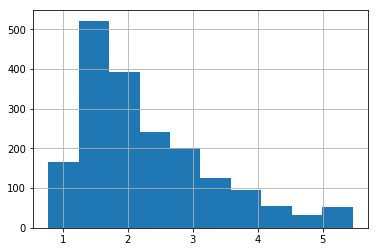

In [25]:
#Histogram Kullback-Leiber divergence
%matplotlib inline
KL["KL"].hist()
print "Mean: " + str(KL["KL"].mean())

In [26]:
KL.to_csv("../../KL_evaluation/kl_evaluation_item_based.csv")

In [27]:
output=pd.DataFrame(index=pred_df.index, columns=["TOP", "values", "real_TOP", "real_values", "real_#"])
for user in pred_df.index:
    output["TOP"][user]=pred_df.loc[user].sort_values(ascending=False).index.tolist()
    output["values"][user]=pred_df.loc[user].sort_values(ascending=False).tolist()
    output["real_#"][user]=ratings[user][area_colnames][ratings[user][area_colnames]!=0.0].count()
    output["real_TOP"][user]=ratings[user][area_colnames][ratings[user][area_colnames]!=0.0].sort_values(ascending=False).index.tolist()
    output["real_values"][user]=ratings[user][area_colnames][ratings[user][area_colnames]!=0.0].sort_values(ascending=False).tolist()

In [28]:
output.to_csv("../../Output/output_item_based.csv")

In [29]:
output.head()

,TOP,values,real_TOP,real_values,real_#
Cliente,,,,,
95,"[A237, A225, A169, A196, A305, A272, A344, A24...","[0.023516096504, 0.0168664552495, 0.0147956027...","[A225, A210, A275, A272, A195, A234, A280, A35...","[0.216, 0.064, 0.06, 0.06, 0.048, 0.044, 0.036...",48
10131,"[A210, A236, A151, A195, A245, A315, A252, A21...","[0.0160867781166, 0.0160101316141, 0.015632031...","[A210, A236, A225, A207, A289, A230, A311, A16...","[0.119932432432, 0.114864864865, 0.04898648648...",56
10188,"[A233, A265, A332, A205, A324, A207, A217, A26...","[0.0209641028759, 0.0205013457797, 0.017800614...","[A210, A205, A236, A289, A143, A207, A145, A31...","[0.114285714286, 0.0833333333333, 0.0642857142...",55
10262,"[A345, A172, A331, A351, A210, A241, A294, A33...","[0.0154611321559, 0.0141907479041, 0.013379316...","[A210, A311, A289, A312, A226, A166, A205, A16...","[0.198630136986, 0.109589041096, 0.08219178082...",32
10362,"[A207, A143, A325, A296, A239, A289, A151, A19...","[0.0430765647414, 0.0389633406798, 0.021058378...","[A143, A289, A205, A166, A207, A230, A210, A16...","[0.15595463138, 0.0812854442344, 0.06710775047...",91


In [30]:
#Recommendations output file
recommendations=pd.DataFrame(index=pred_df.index, columns=["TOP12", "values"])
for user in pred_df.index:
    recommendations["TOP12"][user]=pred_df.loc[user][list(set(output["TOP"][user])-set(output["real_TOP"][user]))].sort_values(ascending=False).index.tolist()[:12]
    recommendations["values"][user]=pred_df.loc[user][list(set(output["TOP"][user])-set(output["real_TOP"][user]))].sort_values(ascending=False).tolist()[:12]

In [31]:
recommendations.to_csv("../../Recommendations/recommendations_item_based.csv")

In [32]:
recommendations.head()

,TOP12,values
Cliente,,
95,"[A237, A169, A196, A305, A247, A227, A153, A26...","[0.023516096504, 0.0147956027263, 0.0130087883..."
10131,"[A151, A195, A245, A315, A252, A308, A241, A34...","[0.0156320317356, 0.0135231927034, 0.012920570..."
10188,"[A233, A265, A332, A217, A261, A208, A253, A32...","[0.0209641028759, 0.0205013457797, 0.017800614..."
10262,"[A345, A331, A351, A241, A338, A228, A325, A17...","[0.0154611321559, 0.0133793169663, 0.012950974..."
10362,"[A325, A208, A221, A305, A172, A360, A277, A25...","[0.021058378953, 0.00813148037372, 0.008106697..."


In [33]:
%store df
%store families
%store ratings
%store ratings_train
%store ratings_test
%store train
%store test
%store sim_df
%store pred_df
%store output
%store recommendations

Stored 'df' (DataFrame)
Stored 'families' (DataFrame)
Stored 'ratings' (DataFrame)
Stored 'ratings_train' (DataFrame)
Stored 'ratings_test' (DataFrame)
Stored 'train' (DataFrame)
Stored 'test' (DataFrame)
Stored 'sim_df' (DataFrame)
Stored 'pred_df' (DataFrame)
Stored 'output' (DataFrame)
Stored 'recommendations' (DataFrame)


In [34]:
print("Total time in minutes: " + str((time.time() - global_time)/60.0))

Total time in minutes: 348.077912935
